# M5 Data Preparation

This notebook helps with loading and transforming the M5 dataset into higher-level, aggregate time series. M5, by default, is provided as a set of 30,490 individual time series. These correspond to individual product sales figures at individual Walmart stores. These time series can be naturally aggregated according to a hierarchy: 

<img src="https://www.artefact.com//wp-content/uploads/2021/03/Image-1-.png"/>

As we can see, the 30,490 time series correspond to sales figures for 3049 individual products across 10 stores. The products each belong to one of three product categories (Hobbies, Foods, and Household), which can be further broken down into a total of 7 product subcategories. The 10 stores each belong to one of three states (California, Texas, and Wisconsin). 

Other information are also provided as part of the M5 dataset, including product sell prices and a calendar of important events (e.g. holidays, relevant dates for [nutrition assistance programs](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133614)).

The following code has been adapted from this [repository](https://github.com/matthiasanderer/m5-accuracy-competition) for the official 2nd place M5 solution.

## Load data

In [1]:
import pandas as pd

In [3]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
train = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

## Build aggregate dataset

In [6]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))

  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [8]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(train[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]
all_sales

CPU times: user 133 ms, sys: 140 ms, total: 273 ms
Wall time: 269 ms


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


In [9]:
%%time
# 2. All products by state (3 series)
state_sales = train.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)
state_sales

CPU times: user 734 ms, sys: 813 ms, total: 1.55 s
Wall time: 1.58 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


In [10]:
%%time
# 3. All products by store (10 series)
store_sales = train.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)
store_sales

CPU times: user 735 ms, sys: 1.87 s, total: 2.61 s
Wall time: 2.6 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
1,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
2,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
3,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
4,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
5,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
6,TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
7,WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
8,WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068
9,WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757


In [11]:
%%time
# 4. All products by category (3 series)
cat_sales = train.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)
cat_sales

CPU times: user 725 ms, sys: 279 ms, total: 1 s
Wall time: 1 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,30107,36576,41447,29158,26148,24790,24737,28136,33599,35967
1,HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3871,4893,5016,3528,3629,3740,3475,4143,5333,5280
2,HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,10095,12839,13458,9676,9000,8566,8751,10273,12586,13091


In [12]:
%%time
# 5. All products by department (7 series)
dept_sales = train.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)
dept_sales

CPU times: user 722 ms, sys: 491 ms, total: 1.21 s
Wall time: 1.21 s


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
1,FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
2,FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
3,HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
4,HOBBIES_2,154,185,185,138,100,87,89,155,158,...,449,479,552,419,487,449,448,382,501,560
5,HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
6,HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


In [13]:
## TOP LEVEL aggregates + TOTAL
all_aggregates = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)
all_aggregates

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
1,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
2,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
3,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
4,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
5,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
6,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
7,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
8,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
9,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217


In [30]:
main_df = all_aggregates.set_index('id_str').T
main_df['date'] = calendar[['d', 'date']].set_index('d')['date']
main_df = main_df.set_index('date')
main_df.index = pd.DatetimeIndex(main_df.index)
main_df

id_str,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,37096,15678,10375,11043,3995,3789,5375,2519,3147,3518,...,24790,3740,8566,3073,4648,17069,3291,449,6641,1925
2016-05-19,36963,16297,9162,11504,4136,4037,5580,2544,2748,3126,...,24737,3475,8751,3251,4551,16935,3027,448,6759,1992
2016-05-20,42552,17430,12303,12819,4433,4751,5542,2704,3664,4249,...,28136,4143,10273,3735,4815,19586,3761,382,7974,2299


# Aggregate time series visualization

Visualize data using different aggregation levels, e.g. by product category and by state. Scale the data to help vizualize differences in patterns. 

In [44]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

Text(0.5, 1.0, 'Total Sales By Product Category')

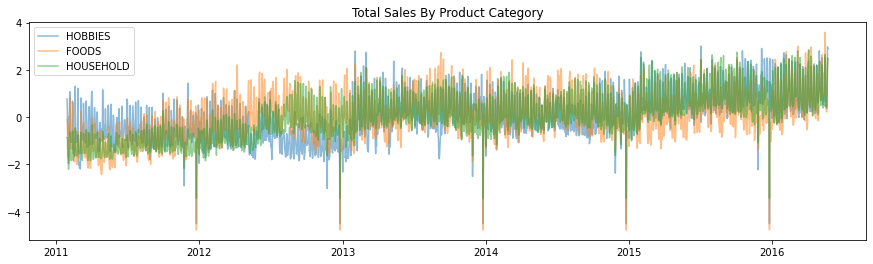

In [51]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(main_df.index, scale(main_df['HOBBIES']), label='HOBBIES', alpha=0.5)
ax.plot(main_df.index, scale(main_df['FOODS']), label='FOODS', alpha=0.5)
ax.plot(main_df.index, scale(main_df['HOUSEHOLD']), label='HOUSEHOLD', alpha=0.5)
plt.legend()
plt.title("Total Sales By Product Category")

Text(0.5, 1.0, 'Total Sales By State')

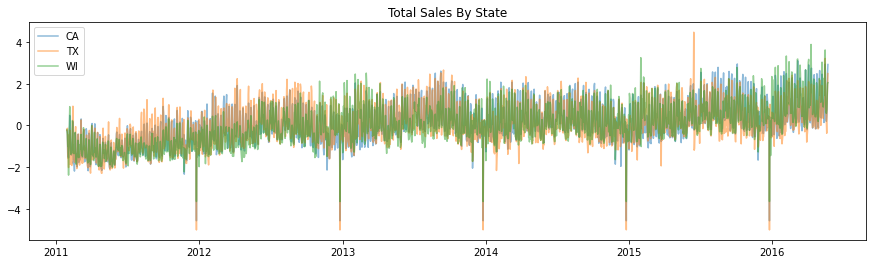

In [52]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(main_df.index, scale(main_df['CA']), label='CA', alpha=0.5)
ax.plot(main_df.index, scale(main_df['TX']), label='TX', alpha=0.5)
ax.plot(main_df.index, scale(main_df['WI']), label='WI', alpha=0.5)
plt.legend()
plt.title("Total Sales By State")

## Visualize individual product sales time series.

In [59]:
product_sales = train[ts_cols].T
product_sales['date'] = calendar[['d', 'date']].set_index('d')['date']
product_sales = product_sales.set_index('date')
product_sales.index = pd.DatetimeIndex(product_sales.index)
product_sales

id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,0,0,0,1,0,0,1,5,0,1,...,3,6,3,0,0,1,0,1,0,0
2016-05-19,3,0,2,3,0,0,0,4,0,1,...,1,4,3,1,2,0,1,0,1,2
2016-05-20,3,0,3,0,2,5,1,1,0,0,...,3,4,3,1,1,0,0,1,1,2


<AxesSubplot:xlabel='date'>

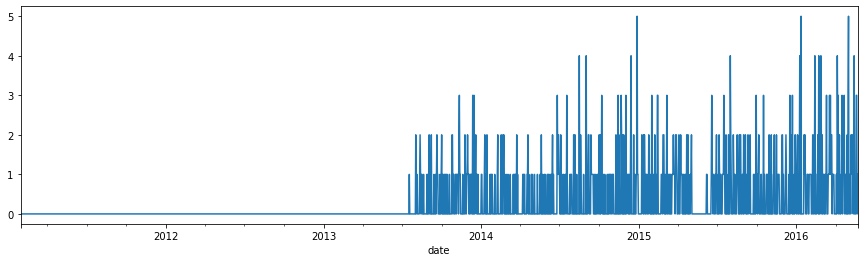

In [60]:
product_sales['HOBBIES_1_001_CA_1_evaluation'].plot(figsize=(15,4))

<AxesSubplot:xlabel='date'>

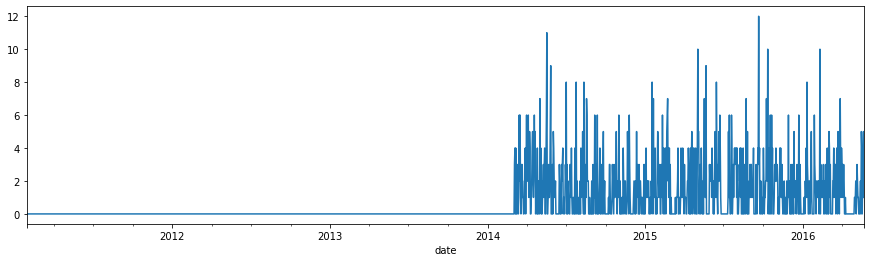

In [61]:
product_sales['FOODS_3_827_WI_3_evaluation'].plot(figsize=(15,4))